In [1]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

api = wandb.Api(timeout=60)

In [4]:
_untapped_potential = 'graph/untapped-potential'
_active_weights_abs = "graph/active-weights-abs"
_pparams = "meta/pparams"

runs = []
for sweep_id in ['f9zju9yb', '01ayiisq']:
    runs += [run for run in api.sweep('concat_moons/' + sweep_id).runs]

histories = [run.history() for run in runs]
configs = [run.config for run in runs]

In [14]:
SAVE = True

964
5676
138
132
238
74


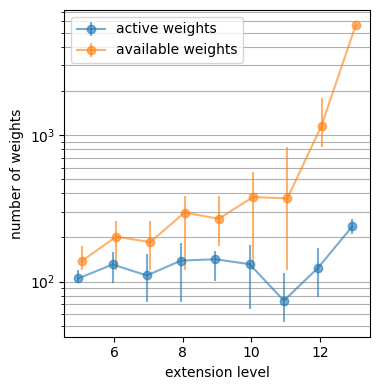

In [15]:
# active vs pparams at first degradation level or split level
active, pparams, extensionlevels = [], [], []
for h, c in zip(histories, configs):
    potential = h[_untapped_potential].values
    indices_split = list(np.where(potential == 0)[0])
    indices_degraded = list(np.where(potential < 0)[0])
    
    indices = (  # swap for 'is_degraded' if desired
        indices_split
        #indices_degraded
    )
    if indices:
        active.append(h[_active_weights_abs][indices[0]])
        pparams.append(h[_pparams][indices[0]])
        extensionlevels.append(c['extension_levels'])

group = pd.DataFrame({'active' : active,'pparams' : pparams,'level' : extensionlevels}).groupby('level')

plt.figure(figsize=(4, 4))

x = group.mean().index
y = group.mean()['active']
y_min = y - group.min()['active']
y_max = group.max()['active'] - y

plt.errorbar(x=x-0.05, y=y, yerr=np.stack([y_min, y_max]), marker='o', alpha=0.6, label=f'active weights')

y = group.mean()['pparams']
y_min = y - group.min()['pparams']
y_max = group.max()['pparams'] - y

plt.errorbar( x=x+0.05, y=y, yerr=np.stack([y_min, y_max]), alpha=0.6,marker='o',label=f'available weights')
plt.xlabel('extension level'), plt.ylabel('number of weights'), plt.legend(loc='upper left'), plt.tight_layout()
plt.gca().xaxis.get_major_locator().set_params(integer=True)

plt.grid(which='minor',  axis='y')
plt.grid(which='major', axis='y')
if SAVE: plt.savefig('1-layer-active-available-at-degrade.png')

plt.yscale('log')
if SAVE: plt.savefig('1-layer-active-available-at-degrade-log.png')

print(int(group.mean()["pparams"].mean()))
print(int(group.mean()["pparams"].max()))
print(int(group.mean()["pparams"].min()))
print(int(group.mean()["active"].mean()))
print(int(group.mean()["active"].max()))
print(int(group.mean()["active"].min()))

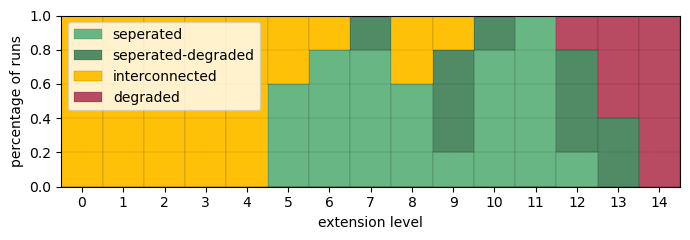

In [20]:
# histogram of number of networks that split
split, degrade, extensionlevels, split_degrade, connected = [], [], [], [], []
for h, c in zip(histories, configs):
    potential = h[_untapped_potential].values
    indices_split = list(np.where(potential == 0)[0])
    indices_degraded = list(np.where(potential < 0)[0])

    split.append(1 if indices_split and not indices_degraded else 0)
    degrade.append(1 if indices_degraded and not indices_split else 0)
    split_degrade.append(1 if indices_degraded and indices_split else 0)
    connected.append(1 if not indices_degraded and not indices_split else 0)
    extensionlevels.append(c['extension_levels'])

df = pd.DataFrame({
    'seperated' : split, 
    'seperated-degraded': split_degrade, 
    'interconnected' :connected, 
    'degraded' : degrade, 
    'extension level' : extensionlevels
})

df.groupby('extension level').mean().plot.bar(
    width=1.,  
    rot=0,  
    stacked=True,
    color=['#68B684', '#508B65', '#FFC107', '#B84A62'],
    figsize=(7,2.5),
    linewidth=0.1,
    edgecolor='k'
).grid(axis='y', linestyle='--', color='k', linewidth=0.1)
plt.ylabel('percentage of runs')
#plt.yticks([0, 0.25, .5, .75, 1])
plt.ylim((0,1)), plt.xlim((-0.5, len(df.groupby('extension level').mean())-0.5))
plt.legend(loc='upper left')
plt.tight_layout()
if SAVE : plt.savefig('1-layer-histogram-split-behaviour.png')